The Cox partial likelihood, is obtained by using Breslow's estimate of the baseline hazard function, plugging it into the full likelihood and then observing that the result is a product of two factors. The first factor is the partial likelihood, in which the baseline hazard has "canceled out". The second factor is free of the regression coefficients and depends on the data only through the censoring pattern. The effect of covariates estimated by any proportional hazards model can thus be reported as hazard ratios.

In [60]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_flchain
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

plt.rcParams['figure.figsize'] = [7.2, 4.8]

In [61]:
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [62]:
num_columns = ['age', 'creatinine', 'kappa', 'lambda']

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_train = imputer.transform(x_train.loc[:, num_columns])
x_test = imputer.transform(x_test.loc[:, num_columns])

In [63]:
y_events = y_train[y_train['death']]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test['death']]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

In [64]:
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


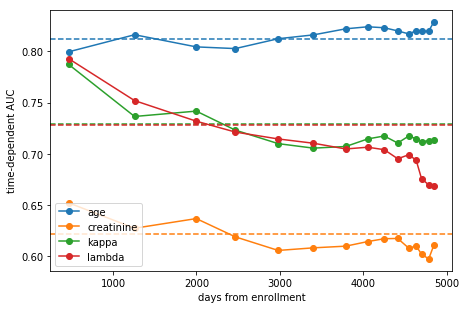

In [65]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

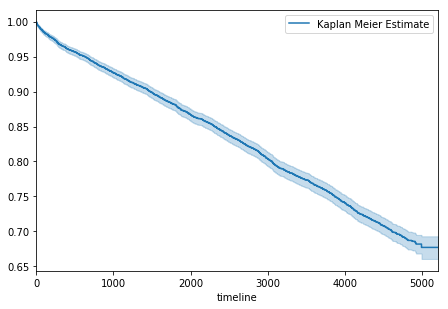

In [66]:
## Lets create an overall KaplanMeier curve
import lifelines

from lifelines import KaplanMeierFitter

durations = y_train['futime'] ## Time to event data of censored and event data
event_observed = y_train['death']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

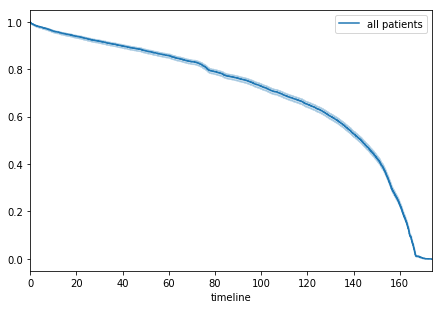

In [67]:
# Duration of patient following in months
T = [i / 30. for i in y_train["futime"]]
# Observation of death in boolean
# True for observed event (death);
# else False (this includes death not observed; death by other causes)
C = [True if i is not pd.NaT else False for i in y_train["death"]]

fitter = KaplanMeierFitter()
fitter.fit(T, event_observed=C, label="all patients")
fitter.plot(show_censors=True)

we will fit an actual survial model to predict the risk of death. After fitting a Cox proportional hazards model, we want to assess how well the model can distinguish survivors from deceased in weekly intervals, up to 6 months after enrollment.

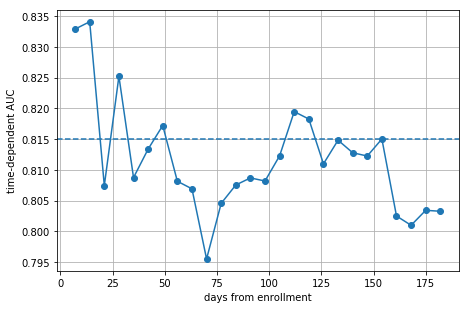

In [68]:
va_x, va_y = load_flchain()
va_x = va_x.drop(columns="chapter")
va_x['creatinine'] = va_x['creatinine'].fillna(va_x['creatinine'].median())

cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(va_x, va_y)

va_times = np.arange(7, 183, 7)
# estimate performance on training data, thus use `va_y` twice.
va_auc, va_mean_auc = cumulative_dynamic_auc(va_y, va_y, cph.predict(va_x), va_times)

plt.plot(va_times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)